In [1]:
# Goal: Develop simple parametric model for lightcurve interpolation and parameter extraction
#       Using george for interpolation

In [2]:
import os,sys
import numpy as np
import matplotlib.pyplot as plt
import astropy.table as table
import scipy.optimize as optimize
import george
import george.modeling as model
from george import kernels
import emcee
import corner

try:
    import snelib19odp
except ImportError:
    sys.path.append('../lib')
import snelib19odp.dataloader as dataloader
import snelib19odp.const as const
import snelib19odp.blackbody as blackbody
import snelib19odp.gaussian as gaussian
import snelib19odp.cauchy as cauchy

In [3]:
# load data
ztflc = table.Table.read('../data/ztflc_forcefit.h5')
ztflc['mag'] = -2.5*np.log10(ztflc['ampl']) + ztflc['magzp']
ztflc['mag_err'] = ztflc['ampl.err']/ztflc['ampl']*1.087 + ztflc['magzprms']
ztflc['phase'] = ztflc['obsmjd'] - const.sne_peak_mjd['g']

# plot ztflc
scalezp = 0
f0coef = 3631e6 * 10 ** (-(ztflc["magzp"] - scalezp) / 2.5)
ztflc['flux_uJy'] = f0coef*ztflc['ampl']
ztflc['flux_uJy.err'] = f0coef*ztflc['ampl.err']


ztflc.sort('obsmjd')
ztflc

<ipython-input-3-0e307ba56b80>:3: RuntimeWarning: invalid value encountered in log10
  ztflc['mag'] = -2.5*np.log10(ztflc['ampl']) + ztflc['magzp']


<Table length=233>
      sigma             sigma.err      ...    flux_uJy.err   
     float64             float64       ...      float64      
------------------ ------------------- ... ------------------
 5.084136052596823 0.14598030314058213 ... 2.7083088316365016
 4.429017756876249 0.13089623320578814 ...  3.270060528419768
7.5097771045959565 0.21343025115356465 ...  4.240774837922197
 4.312240386808786 0.11895011491891837 ...  2.223992922113741
 6.920073204906437 0.20183763719483674 ... 3.0135158160912683
 4.847475113950799 0.14199017641917233 ... 2.6506900911732445
 8.468640852051923 0.23663097108285228 ...  4.385266402671714
5.7556202461528025 0.16507011574947664 ...  5.955187415003999
10.685178556147084 0.11571123951332839 ...  4.433271493834123
12.701894355627289  0.3536305646637821 ...  5.786743067209184
               ...                 ... ...                ...
11.756126965829814 0.33270753646618856 ...  4.862371077801248
10.508604769883636  0.2980412226697699 ... 4.6299851647745385
13.380180036161295 0.37292168647668056 ...  5.306004638971929
15.854730822439397 0.46644715869210285 ...  6.887659454208734
 13.60963241181266 0.38560315389397826 ... 6.3722244948161535
 11.16743042466407  0.3051480017291456 ...  5.580622812030493
 7.608362038731256 0.21204732924074718 ... 2.8037059445626853
 5.380505973919246  0.1545084515835955 ...  2.261786531365851
 4.823029789358324 0.13353517841322923 ... 1.7938429799120648
 4.998202581685263 0.13419440737214583 ...  1.883218187876832

In [30]:
class LateDecayNPeak(model.Model):
    parameter_names = ('y0', 'slope', 'g0', 't0','sigma', 'rise_t0', 'rise_timescale', 'plateau_level')#, 'plateau_end')
    
    def get_value(self, x):
        #phase = x - const.sne_peak_mjd['g']
        phase = x - self.t0
        
        idx = phase < -5
        #ret = np.empty(len(x))
        ret = (self.y0 + self.slope / 1e3 * phase)/(1-np.exp((self.rise_t0-x)/self.rise_timescale)) + self.g0 * np.exp(-phase**2 / 2 / self.sigma**2)
        idx = np.logical_and(idx, ret > self.plateau_level)
        ret[idx] = self.plateau_level
        #ret[~idx] = 0
        return ret
    


In [31]:
idx = ztflc['phase'] > -20
idx = np.logical_and(idx, ztflc['filter'] == 'ZTF_r') 
lc = ztflc[idx]

t = lc['obsmjd']
y = lc['mag']
yerr = lc['mag_err']

BOUNDS = {
    'y0': (10, 30),
    'g0': (-10, 0),
    'sigma': (5, 50),
    'slope': (0, 100),
    'rise_t0': (t.min()-20, t.min()),
    'rise_timescale': (1, 20),
    't0': (const.sne_peak_mjd['g'] - 6, const.sne_peak_mjd['g'] + 6),
    'plateau_level': (17, 23),
    #'plateau_end': (t.min(), t.min()+10)
}

pinit = {
    'y0': 18,
    'slope': 10,
    'g0': -3,
    'sigma': 20,
    'rise_t0': t.min(),
    'rise_timescale': 10,
    't0': const.sne_peak_mjd['g'],
    'plateau_level': 18.5,
    #'plateau_end': t.min()+5
}

<ipython-input-30-cec099230271>:10: RuntimeWarning: divide by zero encountered in true_divide
  ret = (self.y0 + self.slope / 1e3 * phase)/(1-np.exp((self.rise_t0-x)/self.rise_timescale)) + self.g0 * np.exp(-phase**2 / 2 / self.sigma**2)


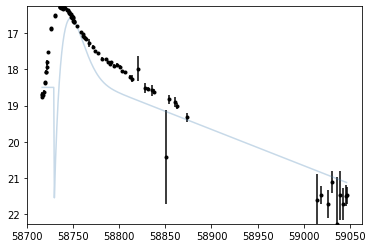

In [32]:
gp = george.GP(mean=LateDecayNPeak(**pinit))
gp.compute(t, yerr)

t_grid = np.linspace(t.min(), t.max(), 500)

# Plot the data.
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)

plt.plot(t_grid, gp.mean.get_value(t_grid), color="#4682b4", alpha=0.3)
plt.ylim((y.min(), y.max()))
plt.gca().invert_yaxis()

In [33]:
gp = george.GP(mean=LateDecayNPeak(bounds=BOUNDS, **pinit))
gp.compute(t, yerr)


def lnprob(p):
    gp.set_parameter_vector(p)
    return gp.log_likelihood(y, quiet=True) + gp.log_prior()

initial = gp.get_parameter_vector()
ndim, nwalkers = len(initial), 32
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

print("Running burn-in...")
p0, _, _ = sampler.run_mcmc(p0, 500)
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, 1000);

Running burn-in...


/home/welterde/.local/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
<ipython-input-30-cec099230271>:10: RuntimeWarning: divide by zero encountered in true_divide
  ret = (self.y0 + self.slope / 1e3 * phase)/(1-np.exp((self.rise_t0-x)/self.rise_timescale)) + self.g0 * np.exp(-phase**2 / 2 / self.sigma**2)


Running production...


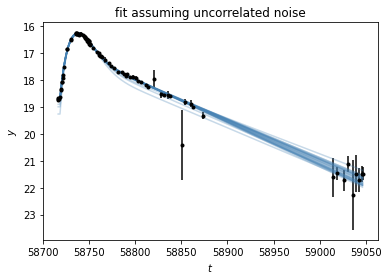

In [34]:
# Plot the data.
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)

# The positions where the prediction should be computed.
t_grid = np.linspace(t.min(), t.max(), 500)

# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    gp.set_parameter_vector(s)
    plt.plot(t_grid, gp.mean.get_value(t_grid), color="#4682b4", alpha=0.3)

plt.ylabel(r"$y$")
plt.xlabel(r"$t$")
plt.gca().invert_yaxis()
plt.title("fit assuming uncorrelated noise");

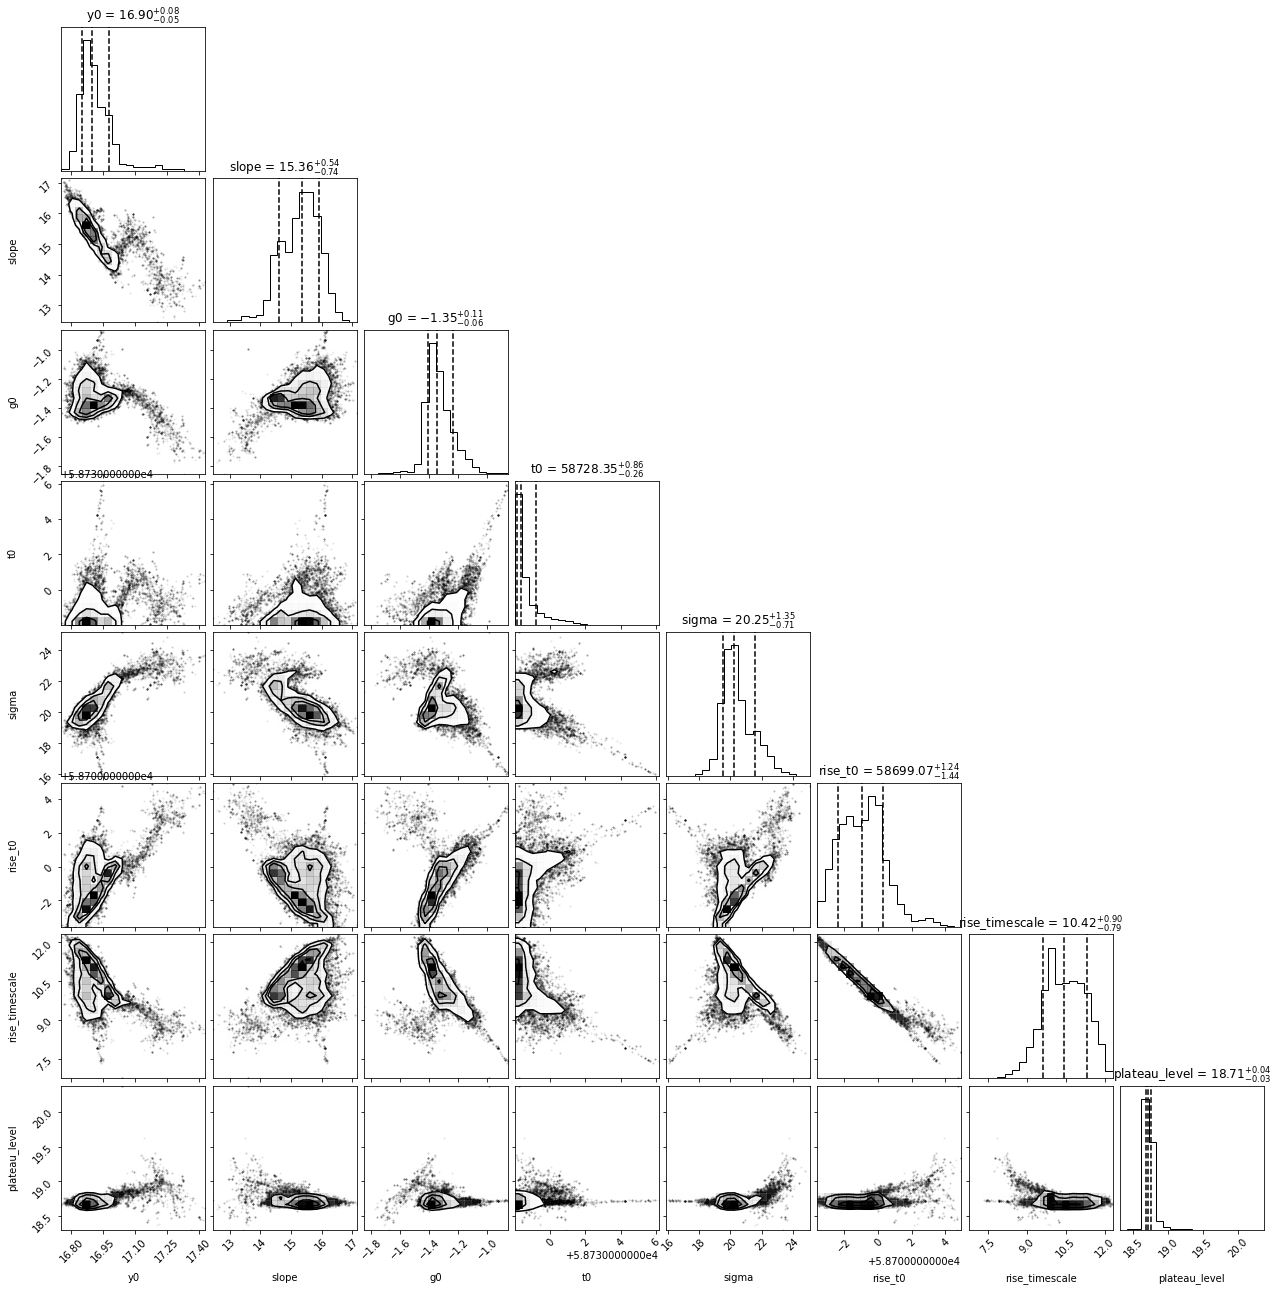

In [35]:
#tri_cols = ["amp", "location", "log_sigma2"]
tri_cols = [a.split(':')[1] for a in gp.get_parameter_names()]
#tri_labels = [r"$\alpha$", r"$\ell$", r"$\ln\sigma^2$"]
#tri_truths = [truth[k] for k in tri_cols]
#tri_range = [(-2, -0.01), (-3, -0.5), (-1, 1)]
names = gp.get_parameter_names()
inds = np.array([names.index("mean:"+k) for k in tri_cols])
corner.corner(sampler.flatchain[:, inds], labels=tri_cols, quantiles=[0.16, 0.5, 0.84], show_titles=True);

In [36]:
gp = george.GP(np.var(y) * kernels.Matern32Kernel(30.0, block=(10, 150)), mean=LateDecayNPeak(bounds=BOUNDS, **pinit))
gp.compute(t, yerr)

def lnprob2(p):
    gp.set_parameter_vector(p)
    return gp.log_likelihood(y, quiet=True) + gp.log_prior()

initial = gp.get_parameter_vector()
ndim, nwalkers = len(initial), 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob2)

print("Running first burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 2000)

print("Running second burn-in...")
p0 = p0[np.argmax(lp)] + 1e-8 * np.random.randn(nwalkers, ndim)
sampler.reset()
p0, _, _ = sampler.run_mcmc(p0, 2000)
sampler.reset()

print("Running third burn-in...")
p0 = p0[np.argmax(lp)] + 1e-8 * np.random.randn(nwalkers, ndim)
sampler.reset()
p0, _, _ = sampler.run_mcmc(p0, 2000)
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, 8000);

Running first burn-in...


/home/welterde/.local/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
<ipython-input-30-cec099230271>:10: RuntimeWarning: divide by zero encountered in true_divide
  ret = (self.y0 + self.slope / 1e3 * phase)/(1-np.exp((self.rise_t0-x)/self.rise_timescale)) + self.g0 * np.exp(-phase**2 / 2 / self.sigma**2)


Running second burn-in...
Running third burn-in...
Running production...


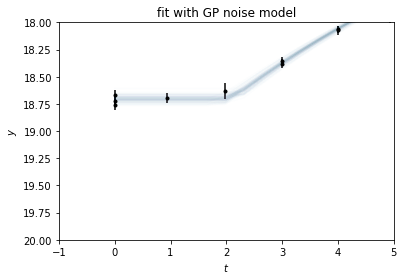

In [37]:
# Plot the data.
plt.errorbar(t - t.min(), y, yerr=yerr, fmt=".k", capsize=0)

# The positions where the prediction should be computed.
x_grid = np.linspace(t.min(), t.max(), 1000)

# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=100)]:
    gp.set_parameter_vector(s)
    mu = gp.sample_conditional(y, x_grid)
    plt.plot(x_grid - t.min(), mu, color="#4682b4", alpha=0.01)

plt.ylabel(r"$y$")
plt.xlabel(r"$t$")
plt.xlim(-1, 5)
plt.ylim((18,20))
plt.gca().invert_yaxis()
plt.title("fit with GP noise model");

['y0', 'slope', 'g0', 't0', 'sigma', 'rise_t0', 'rise_timescale', 'plateau_level', 'k1', 'k2']
('mean:y0', 'mean:slope', 'mean:g0', 'mean:t0', 'mean:sigma', 'mean:rise_t0', 'mean:rise_timescale', 'mean:plateau_level', 'kernel:k1:log_constant', 'kernel:k2:metric:log_M_0_0')


ValueError: It looks like the parameter(s) in column(s) 9 have no dynamic range. Please provide a `range` argument.

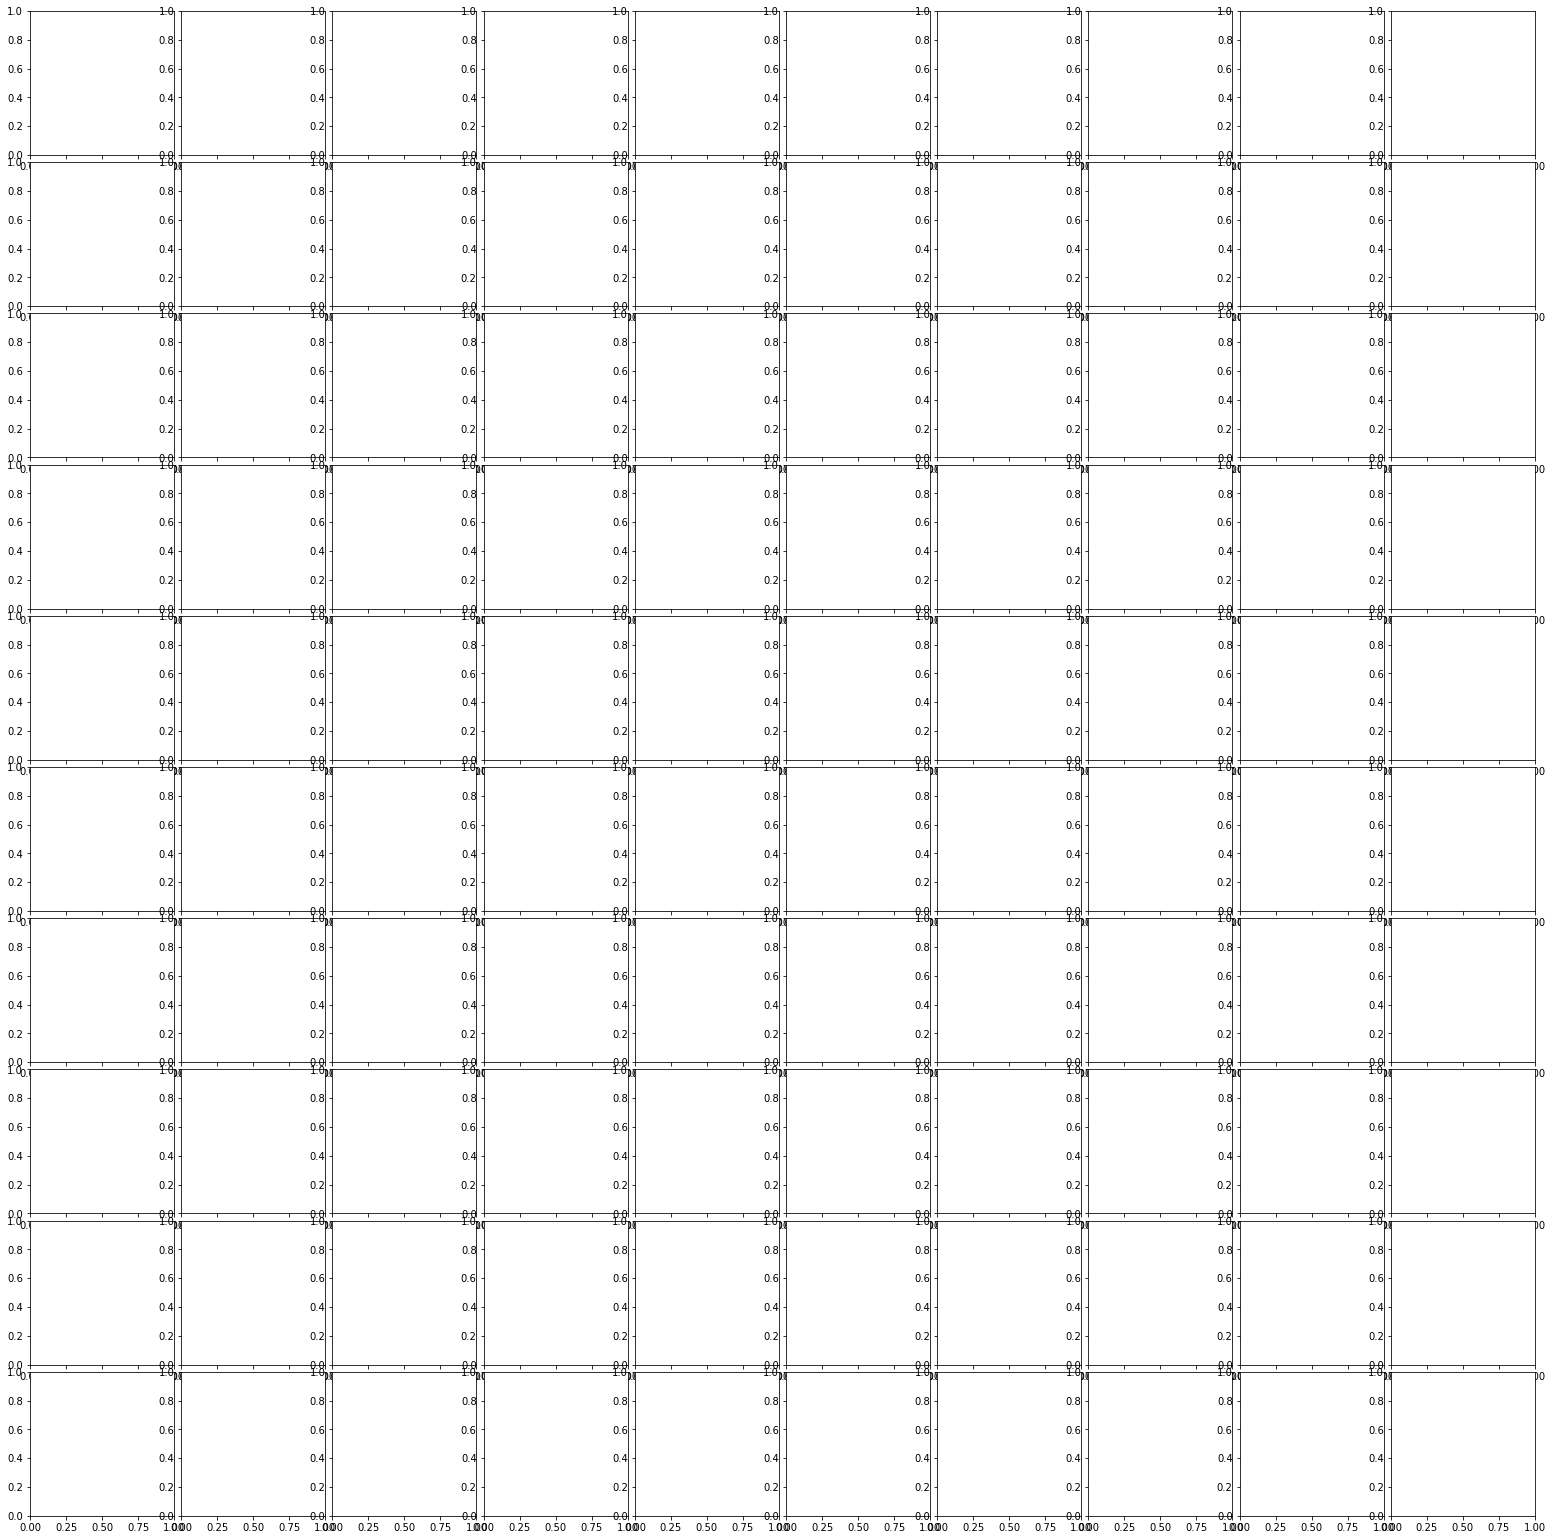

In [38]:
#tri_cols = ["amp", "location", "log_sigma2"]
tri_cols = [a.split(':')[1] for a in gp.get_parameter_names()]
#tri_labels = [r"$\alpha$", r"$\ell$", r"$\ln\sigma^2$"]
#tri_truths = [truth[k] for k in tri_cols]
#tri_range = [(-2, -0.01), (-3, -0.5), (-1, 1)]
print(tri_cols)
print(gp.get_parameter_names())
names = gp.get_parameter_names()
#inds = np.array([names.index("mean:"+k) for k in tri_cols])
corner.corner(sampler.flatchain, labels=gp.get_parameter_names(), quantiles=[0.16, 0.5, 0.84], show_titles=True);